In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor

## Ex1

In [2]:
def build_weighted_graph_from_edgelist(path, max_rows=1500):
    G = nx.Graph()
    with open(path, "r") as f:
        for i, line in enumerate(f):
            if i >= max_rows:
                break
            a, b = line.strip().split()
            a, b = int(a), int(b)

            if G.has_edge(a, b):
                G[a][b]["weight"] += 1
            else:
                G.add_edge(a, b, weight=1)
    return G


def egonet_features(G):
    N = {}
    E = {}
    W = {}
    lam_w = {}

    for node in G.nodes():
        ego = nx.ego_graph(G, node, radius=1, center=False)
        N[node] = ego.number_of_nodes()
        E[node] = ego.number_of_edges()
        W[node] = ego.size(weight="weight")

        if ego.number_of_nodes() == 0:
            lam_w[node] = 0.0
        else:
            A = nx.to_numpy_array(ego, weight="weight")
            vals, _ = np.linalg.eigh(A)
            lam_w[node] = float(np.max(vals)) if len(vals) > 0 else 0.0

    nx.set_node_attributes(G, N, "Ni")
    nx.set_node_attributes(G, E, "Ei")
    nx.set_node_attributes(G, W, "Wi")
    nx.set_node_attributes(G, lam_w, "lambda_w")

    return N, E, W, lam_w


def powerlaw_scores_from_xy(x, y):
    x = np.asarray(x).astype(float)
    y = np.asarray(y).astype(float)

    eps = 1e-12
    x = np.clip(x, eps, None)
    y = np.clip(y, eps, None)

    logx = np.log(x).reshape(-1, 1)
    logy = np.log(y)

    reg = LinearRegression()
    reg.fit(logx, logy)

    theta = float(reg.coef_[0])
    logC = float(reg.intercept_)
    C = float(np.exp(logC))

    y_hat = C * (x ** theta)

    score = (np.maximum(y, y_hat) / np.maximum(np.minimum(y, y_hat),
             eps)) * np.log(np.abs(y - y_hat) + 1.0)
    return score, C, theta


def minmax_norm(a):
    a = np.asarray(a, dtype=float)
    mn, mx = np.min(a), np.max(a)
    if mx - mn < 1e-12:
        return np.zeros_like(a)
    return (a - mn) / (mx - mn)

In [3]:
path = "ca-AstroPh.txt"

G = build_weighted_graph_from_edgelist(path, max_rows=1500)
N, E, W, lam_w = egonet_features(G)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Nodes: 1103
Edges: 1458


Top 10 nodes (power-law Ei vs Ni): [101811, 126916, 84424, 127393, 94138, 60471, 76529, 109229, 106274, 75731]
Fitted theta: 0.9537678636468392 C: 0.5404519121020976


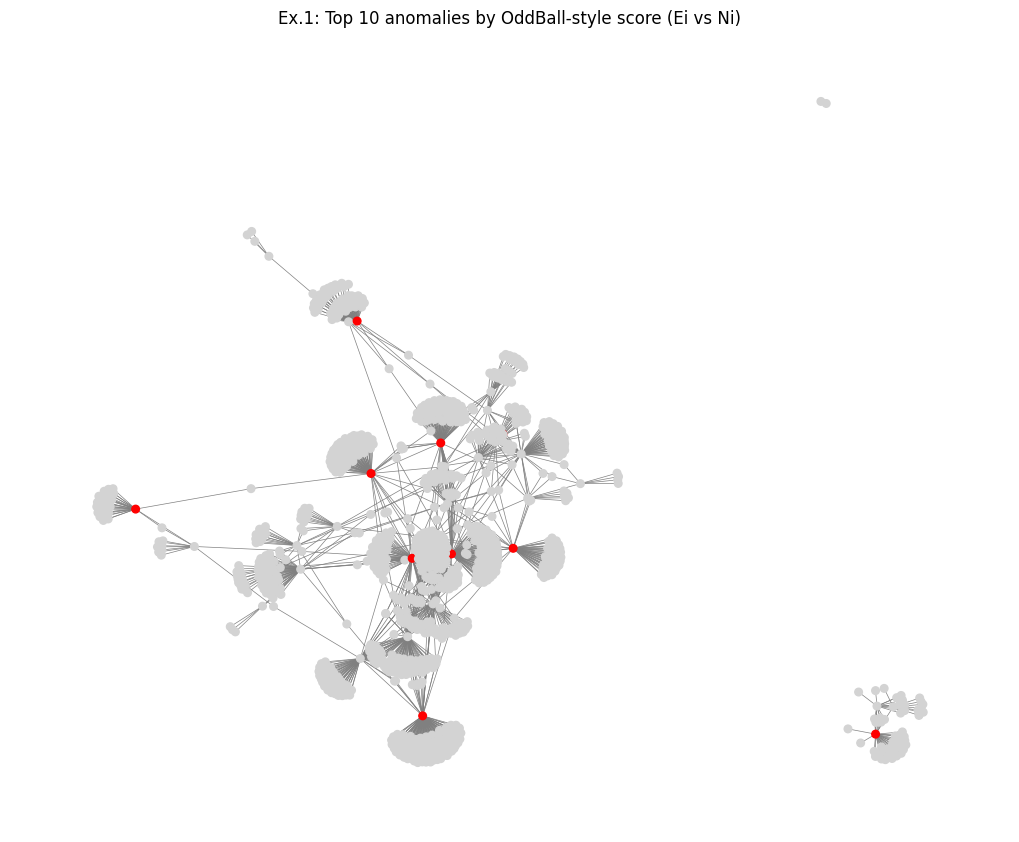

In [4]:
nodes = list(G.nodes())

Ni = np.array([G.nodes[u]["Ni"] for u in nodes])
Ei = np.array([G.nodes[u]["Ei"] for u in nodes])

scores_EN, C_en, theta_en = powerlaw_scores_from_xy(
    Ni + 1.0, Ei + 1.0) 

order = np.argsort(scores_EN)[::-1]
top10_nodes = [nodes[i] for i in order[:10]]

print("Top 10 nodes (power-law Ei vs Ni):", top10_nodes)
print("Fitted theta:", theta_en, "C:", C_en)

color = ["red" if u in top10_nodes else "lightgray" for u in G.nodes()]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=color, node_size=30,
        edge_color="gray", width=0.5, with_labels=False)
plt.title("Ex.1: Top 10 anomalies by OddBall-style score (Ei vs Ni)")
plt.show()

Top 10 nodes (OddBall score + LOF): [5412, 101811, 92357, 126916, 71583, 83560, 84424, 127393, 97966, 47255]


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


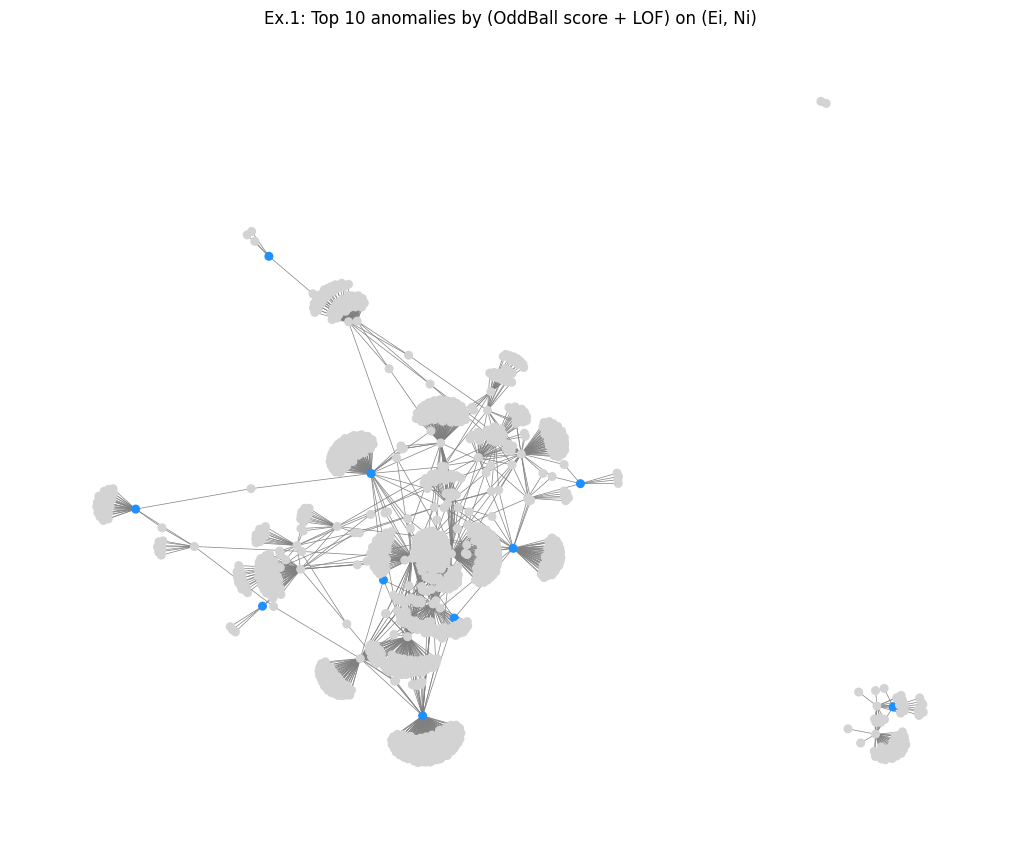

In [5]:
X_feat = np.column_stack([Ei, Ni])

lof = LocalOutlierFactor(n_neighbors=20)
lof_labels = lof.fit_predict(X_feat)
lof_scores = -lof.negative_outlier_factor_  

score_norm = minmax_norm(scores_EN)
lof_norm = minmax_norm(lof_scores)

combined = score_norm + lof_norm

order2 = np.argsort(combined)[::-1]
top10_nodes_2 = [nodes[i] for i in order2[:10]]

print("Top 10 nodes (OddBall score + LOF):", top10_nodes_2)

color2 = ["dodgerblue" if u in top10_nodes_2 else "lightgray" for u in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=color2, node_size=30,
        edge_color="gray", width=0.5, with_labels=False)
plt.title("Ex.1: Top 10 anomalies by (OddBall score + LOF) on (Ei, Ni)")
plt.show()

## Ex2
### 2.1

In [6]:
G1 = nx.random_regular_graph(d=3, n=100, seed=42)
G2 = nx.connected_caveman_graph(l=10, k=20)

Gm = nx.union(G1, G2, rename=("R", "C"))

nodes_all = list(Gm.nodes())
rng = np.random.default_rng(42)

while not nx.is_connected(Gm):
    u = rng.choice(nodes_all)
    v = rng.choice(nodes_all)
    if u != v and (not Gm.has_edge(u, v)):
        Gm.add_edge(u, v, weight=1)

print("Merged graph nodes:", Gm.number_of_nodes())
print("Merged graph edges:", Gm.number_of_edges())
print("Connected:", nx.is_connected(Gm))

Merged graph nodes: 300
Merged graph edges: 2051
Connected: True


Top 10 nodes most likely in clique (Ei vs Ni): ['C199', 'C119', 'C19', 'C159', 'C39', 'C139', 'C132', 'C179', 'C59', 'C99']


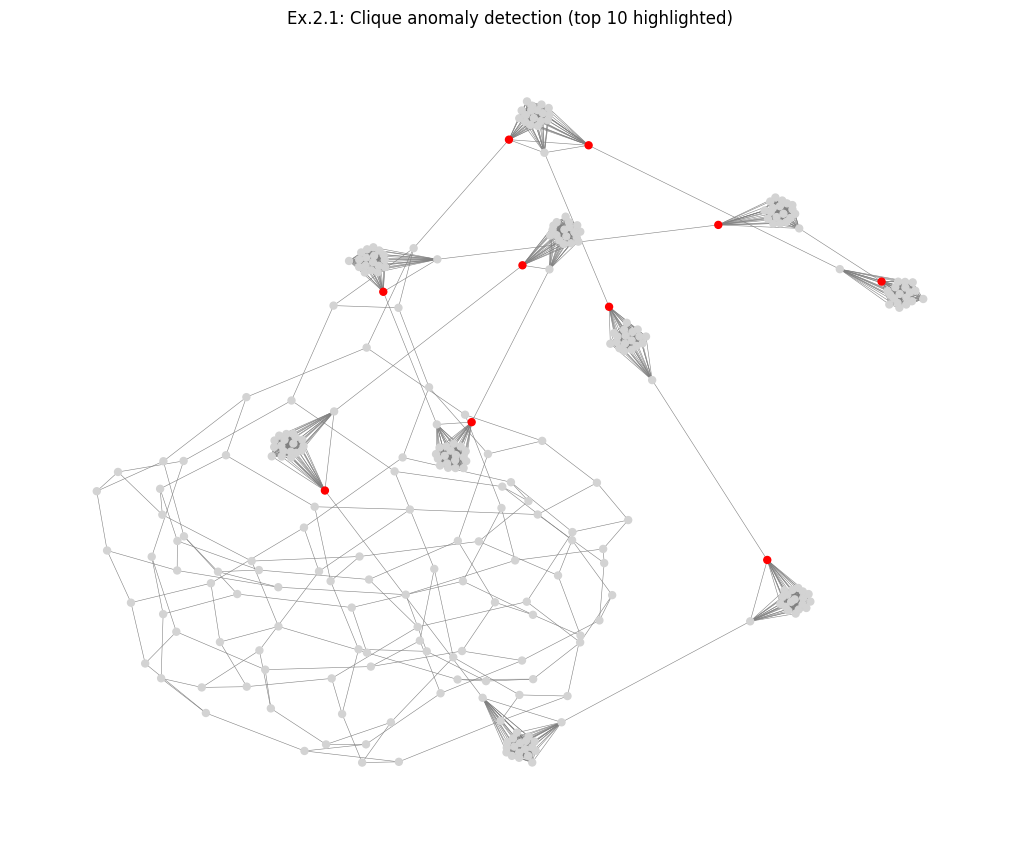

In [7]:
_ = egonet_features(Gm)

nodes_m = list(Gm.nodes())
Ni_m = np.array([Gm.nodes[u]["Ni"] for u in nodes_m])
Ei_m = np.array([Gm.nodes[u]["Ei"] for u in nodes_m])

scores_m, C_m, theta_m = powerlaw_scores_from_xy(Ni_m + 1.0, Ei_m + 1.0)
order = np.argsort(scores_m)[::-1]
top10 = [nodes_m[i] for i in order[:10]]

print("Top 10 nodes most likely in clique (Ei vs Ni):", top10)

pos_m = nx.spring_layout(Gm, seed=42)
color_m = ["red" if u in top10 else "lightgray" for u in Gm.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(Gm, pos_m, node_color=color_m, node_size=25,
        edge_color="gray", width=0.4, with_labels=False)
plt.title("Ex.2.1: Clique anomaly detection (top 10 highlighted)")
plt.show()

### 2.2

In [ ]:
G3 = nx.random_regular_graph(d=3, n=100, seed=42)
G5 = nx.random_regular_graph(d=5, n=100, seed=7)

Gh = nx.union(G3, G5, rename=("D3_", "D5_"))

for u, v in Gh.edges():
    Gh[u][v]["weight"] = 1

random.seed(42)
while not nx.is_connected(Gh):
    comps = list(nx.connected_components(Gh))
    u = random.choice(list(comps[0]))
    v = random.choice(list(comps[1]))
    if not Gh.has_edge(u, v):
        Gh.add_edge(u, v, weight=1)

print("Connected:", nx.is_connected(Gh))

nodes_h = list(Gh.nodes())
rng = np.random.default_rng(42)
chosen = rng.choice(nodes_h, size=2, replace=False).tolist()

for center in chosen:
    ego = nx.ego_graph(Gh, center, radius=1, center=True)
    for u, v in ego.edges():
        Gh[u][v]["weight"] += 10

print("Chosen heavy-vicinity centers:", chosen)

Connected: True
Chosen heavy-vicinity centers: ['D3_11', 'D5_36']


Top 4 nodes (Wi vs Ei heavy-vicinity score): ['D5_54', 'D5_75', 'D5_64', 'D5_22']


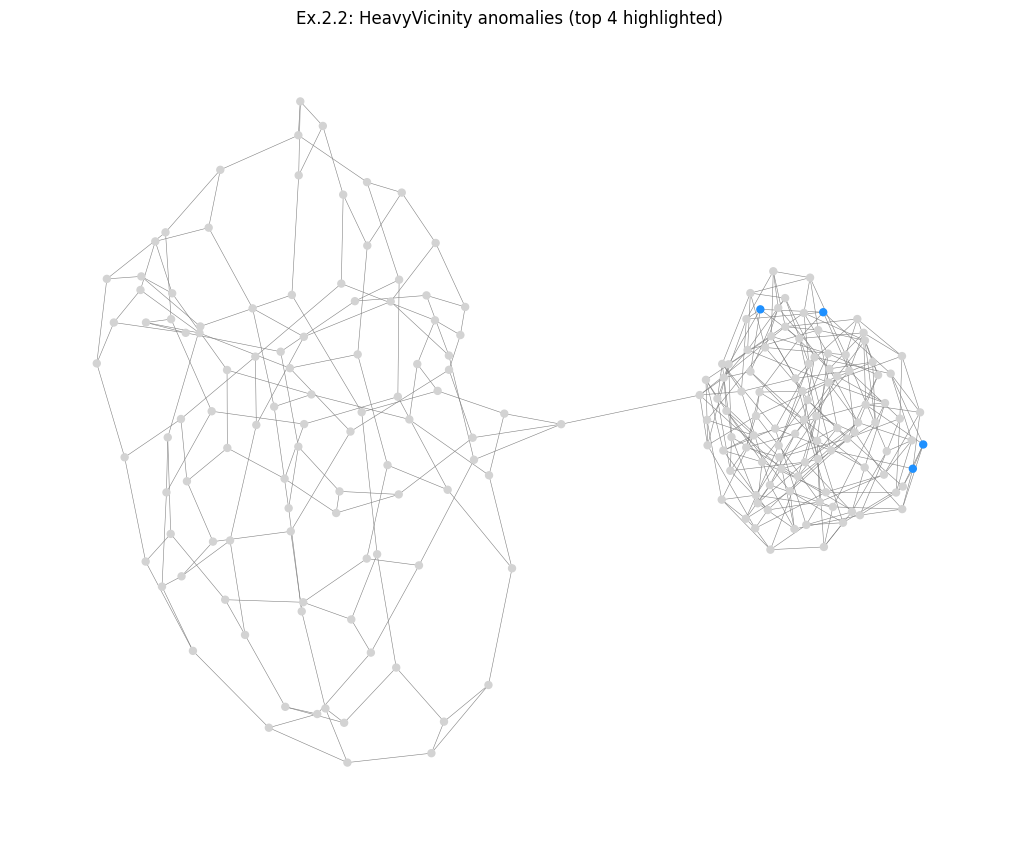

In [ ]:
_ = egonet_features(Gh)

nodes_h = list(Gh.nodes())
Wi_h = np.array([Gh.nodes[u]["Wi"] for u in nodes_h])
Ei_h = np.array([Gh.nodes[u]["Ei"] for u in nodes_h])

scores_WE, C_we, theta_we = powerlaw_scores_from_xy(
    Ei_h + 1.0, Wi_h + 1.0) 
order = np.argsort(scores_WE)[::-1]
top4 = [nodes_h[i] for i in order[:4]]

print("Top 4 nodes (Wi vs Ei heavy-vicinity score):", top4)

pos_h = nx.spring_layout(Gh, seed=42)
color_h = ["dodgerblue" if u in top4 else "lightgray" for u in Gh.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(Gh, pos_h, node_color=color_h, node_size=25,
        edge_color="gray", width=0.4, with_labels=False)
plt.title("Ex.2.2: HeavyVicinity anomalies (top 4 highlighted)")
plt.show()